In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import dare
from kalman import KalmanFilter
import constants as ct
from parameters import *
from particle3D import Particle

In this notebook we will simulate the dynamics of a levitated nanoparticle considering the quantum effects of measurement uncertanty and stochastic quantum force (backaction). This leads to the following dynamics:

$$
m\ddot{x} = -\gamma\dot{x}-k_x x + F_{th}(t) + F_{ba}(t)+bu(t).
$$

Where $m$ is the particle's mass, $\gamma$ the drag coefficient of the medium (for our case will be related to the pressure inside the vacuum chamber), $k_x$ the spring constant of the optical trap (which defines the resonance frequency $\Omega_x$ of the particle for a), $F_{th}$ a stochastic force related to the colision of residual gas molecules with the trapped nano-sphere, $F_{ba}$ the stochastic force of backaction and $bu(t)$ the feedback term.

We can rewrite this dynamics in the state variable form:

$$
\dot{\mathbf{x}} = \mathbf{A}\mathbf{x}+\mathbf{B}\mathbf{u}(t) + \begin{bmatrix}0\\1\end{bmatrix}F_{th}(t)+ \begin{bmatrix}0\\1\end{bmatrix}F_{ba}(t)
$$

Our simulation will consider the state vector of position and momentum for the 3D motion of a nanoparticle. Also, the simulation will be done considering a normalized representation, where the states will be computed in terms of the zero point motion. Given the states computed by the simulation, to encounter the equivalent values in S.I units is necessary to multiple the state related to the position by its respective zero point motion.

Below we will define the parameters necessary for the simulation, they are:

 - `pressure` : Gas pressure in the vacuum chamber.
 - `radius`: Particle`s radius.
 - `wavelength`: Laser wavelenght used for trapping.
 - `power`: Amount of optical power used.
 - `waist`: Beam waist at the focal point.
 - `eta_detection`: Quality of detection, defining how far of the quantum limit we are.
 - `delta_t`: timestep for simulation.
 - `control_step`: multiple of `delta_t` that the controller needs to compute the control law.

From this parameters its possible to compute the frequency of the system, damping of the medium and variance of the stochastic processes that describe the stochastic forces acting on the particle.

In [3]:
delta_t = 1e-9
control_step = int(32e-9/delta_t)
t = np.arange(0, 70 * (1/100e3), delta_t)
N = t.shape[0]
pressure = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6352e-6 
eta_detection = 0.178
fs = 1/(control_step*delta_t)

gamma, _, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist,
                                                                      radius, pressure, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
omegas = np.array([2*np.pi*94e3, 2*np.pi*102e3, 2*np.pi*30e3])

B = np.array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
env = Particle(omegas, gamma, B, coupling, eta_detection=eta_detection, radius=radius)

variance_process_x = env.thermal_force_std_x**2 + env.backaction_std_x**2
variance_process_y = env.thermal_force_std_y**2 + env.backaction_std_y**2
variance_process_z = env.thermal_force_std_z**2 + env.backaction_std_z**2
Q = np.array([[0, 0, 0, 0, 0, 0], 
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, variance_process_x, 0, 0],
            [0, 0, 0, 0, variance_process_y, 0],
            [0, 0, 0, 0, 0, variance_process_z]])*control_step*delta_t/2
R = np.array([[3*np.power(std_detection/env.zp_x, 2), 0, 0],
            [0, 6*np.power(std_detection/env.zp_y, 2), 0],
            [0, 0, np.power(std_detection/env.zp_z, 2)]])

g_fb = 100
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omegas[0]/2, 0, 0, 0, 0, 0],
                        [0, omegas[1]/2, 0, 0, 0, 0],
                        [0, 0, omegas[2]/2, 0, 0, 0],
                        [0, 0, 0, omegas[0]/2, 0, 0],
                        [0, 0, 0, 0, omegas[1]/2, 0],
                        [0, 0, 0, 0, 0, omegas[2]/2]])
control_effort = np.array([[1/(2*omegas[0]), 0, 0],
                        [0, 1/(2*omegas[1]), 0],
                        [0, 0, 1/(2*omegas[2])]])
X, L, G = dare(Ad, Bd, cost_states, control_effort/(g_fb))

In [6]:
x0 = 1e4
P0 = (1e4**2)*np.matrix(np.eye(6))
estimation = np.zeros((6,1))
states = x0*np.ones((6,1))
new_states = np.zeros((N, 6))
measured_states = np.zeros((N,3))
estimated_states = np.zeros((N, 6))
estimated_states[0, :] = estimation[:,0]
control=np.zeros((3,1))
controls = np.zeros((3, N))
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measurement_noise = np.array(
                [np.sqrt(3)*np.random.normal()*std_detection/env.zp_x,
                np.sqrt(6)*np.random.normal()*std_detection/env.zp_y,
                np.random.normal()*std_detection/env.zp_z]
                )
        measured_states[i,:] = env.C@states[:, 0] + measurement_noise
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i].reshape((3,1)))
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((6))
        estimation = estimated_states[i, :].reshape((6, 1))   
        control = -G@estimation
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls[:,i] = control[:,0]
    states = env.step(states, control=control, delta_t=delta_t)

100%|██████████| 700000/700000 [00:47<00:00, 14680.06it/s]


In [4]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_x*1e9*measured_states[::control_step,0], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_x*1e9*new_states[::control_step,0], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_x*1e9*estimated_states[::control_step,0], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle x \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)

NameError: name 'measured_states' is not defined

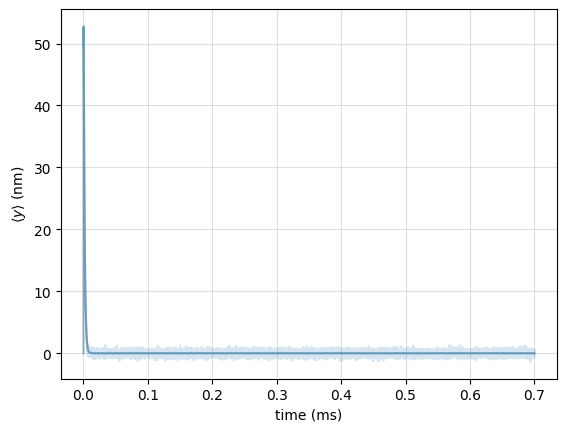

In [ ]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_y*1e9*measured_states[::control_step,1], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*new_states[::control_step,1], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*estimated_states[::control_step,1], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle y \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)

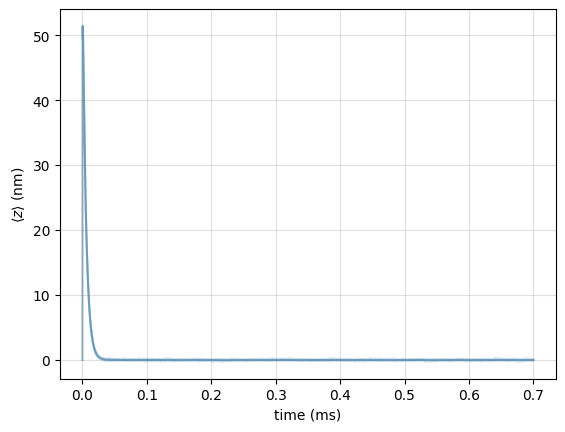

In [ ]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_y*1e9*measured_states[::control_step,2], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*new_states[::control_step,2], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*estimated_states[::control_step,2], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle z \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)